In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from empiricaldist import Pmf, Cdf

from scipy.stats import shapiro, ttest_ind
import statsmodels.formula.api as smf  

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error          

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [2]:
csv_directory = '../data/noise_measures'

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through the files and read them into pandas
for file in csv_files:
    file_path = os.path.join(csv_directory, file)
    df = pd.read_csv(file_path)  # Adjust the delimiter if needed, e.g., sep=";"
    dataframes.append(df)

# Concatenate all DataFrames
df_noise = pd.concat(dataframes, ignore_index=True)

df_noise.head()

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h
0,2015,3,19,0:00,391,66.9
1,2015,3,19,1:00,391,64.5
2,2015,3,19,2:00,391,62.1
3,2015,3,19,3:00,391,61.9
4,2015,3,19,4:00,391,61.0


In [3]:
# Include location of sensors
df_sensors = pd.read_csv('../data/XarxaSoroll_EquipsMonitor_Instal.csv')

df_noise = df_noise.merge(df_sensors[['Id_Instal', 'Latitud', 'Longitud']], on='Id_Instal', how='left')
df_noise.head(5)

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h,Latitud,Longitud
0,2015,3,19,0:00,391,66.9,41.402959,2.137835
1,2015,3,19,1:00,391,64.5,41.402959,2.137835
2,2015,3,19,2:00,391,62.1,41.402959,2.137835
3,2015,3,19,3:00,391,61.9,41.402959,2.137835
4,2015,3,19,4:00,391,61.0,41.402959,2.137835


In [4]:
# Combine the date and time columns into a single DateTimeIndex
df_noise["Datetime"] = pd.to_datetime(df_noise[["Any", "Mes", "Dia"]].astype(str).agg('-'.join, axis=1) + " " + df_noise["Hora"])
df_noise.set_index("Datetime", inplace=True)

# Drop the original columns used to create the DateTimeIndex
df_noise.drop(columns=["Any", "Mes", "Dia", "Hora"], inplace=True)

# Change name of Noise db data
df_noise.rename(columns={'Nivell_LAeq_1h':'Noise_db'}, inplace=True)

# Sort dataframe by index
df_noise.sort_index(inplace=True)
df_noise.head()

,Id_Instal,Noise_db,Latitud,Longitud
Datetime,,,,
2015-01-01 07:00:00,186,74.3,41.395450,2.152753
2015-01-01 07:00:00,187,68.6,41.396156,2.151564
2015-01-01 08:00:00,186,67.4,41.395450,2.152753
2015-01-01 08:00:00,187,65.0,41.396156,2.151564
2015-01-01 09:00:00,186,63.2,41.395450,2.152753


## EDA

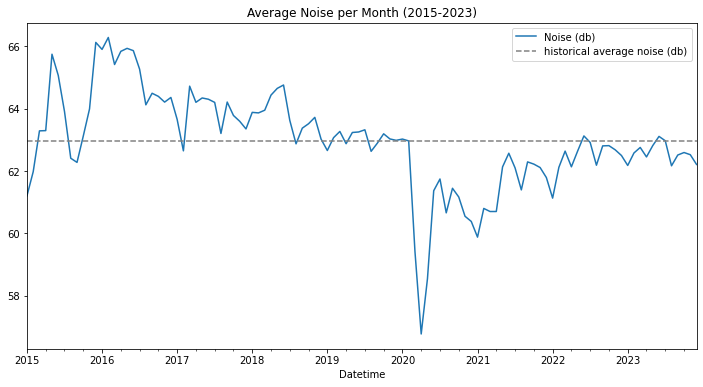

In [5]:
# Mean noise per month
noise_month_year = df_noise['Noise_db'].resample('MS').mean()

# Total sensors per month
sensor_per_month = df_noise['Id_Instal'].resample('MS').sum()

plt.figure(figsize=(12,6))
noise_month_year.plot(label='Noise (db)')
plt.title('Average Noise per Month (2015-2023)')
plt.axhline(np.mean(noise_month_year), linestyle='--', color='grey', label='historical average noise (db)')
plt.legend()
plt.show()

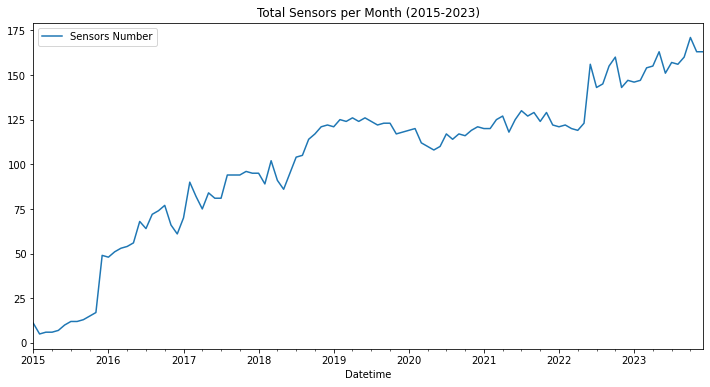

In [6]:
sensor_per_month = df_noise['Id_Instal'].resample('MS').nunique()

plt.figure(figsize=(12,6))
sensor_per_month.plot(label='Sensors Number')
plt.title('Total Sensors per Month (2015-2023)')
plt.legend()
plt.show()

<Axes: xlabel='Datetime', ylabel='Noise_db'>

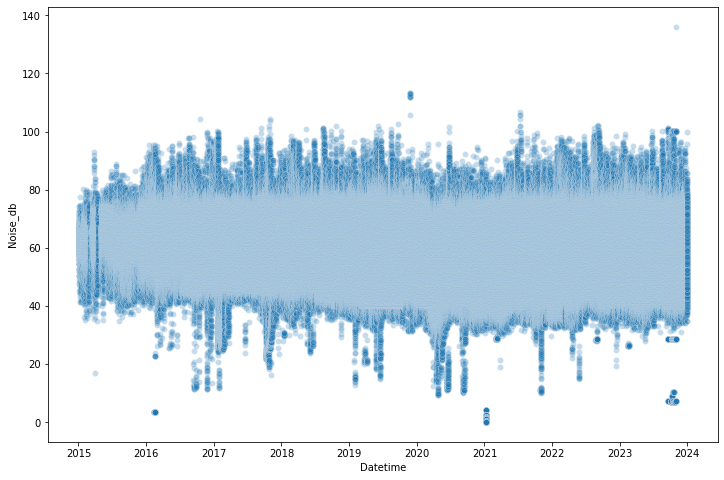

In [7]:
# Create a subplot for noise levels per year

plt.figure(figsize=(12,8))
sns.scatterplot(df_noise['Noise_db'], alpha=0.25)

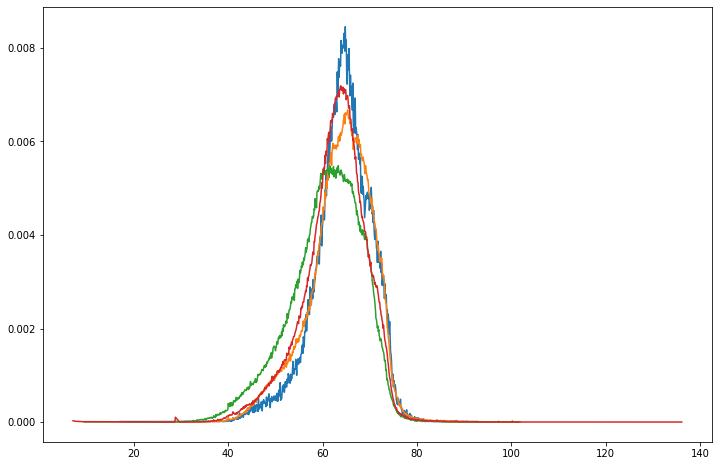

In [8]:
plt.figure(figsize=(12,8))
pmf_2015 = Pmf.from_seq(df_noise.loc['2015', 'Noise_db'])
pmf_2018 = Pmf.from_seq(df_noise.loc['2018', 'Noise_db'])
pmf_2020 = Pmf.from_seq(df_noise.loc['2020', 'Noise_db'])
pmf_2023 = Pmf.from_seq(df_noise.loc['2023', 'Noise_db'])

# Plot the figure
plt.plot(pmf_2015)
plt.plot(pmf_2018)
plt.plot(pmf_2020)
plt.plot(pmf_2023)
plt.show()

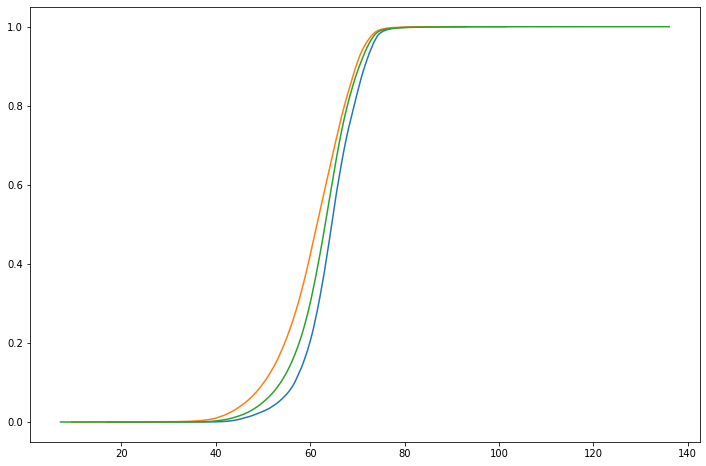

In [9]:
plt.figure(figsize=(12,8))
cdf_2015 = Cdf.from_seq(df_noise.loc['2015', 'Noise_db'])
cdf_2018 = Cdf.from_seq(df_noise.loc['2018', 'Noise_db'])
cdf_2020 = Cdf.from_seq(df_noise.loc['2020', 'Noise_db'])
cdf_2021 = Cdf.from_seq(df_noise.loc['2021', 'Noise_db'])
cdf_2023 = Cdf.from_seq(df_noise.loc['2023', 'Noise_db'])

# Plot the figure
plt.plot(cdf_2015)
plt.plot(cdf_2020)
plt.plot(cdf_2023)
plt.show()

# Time Series of a Sensor

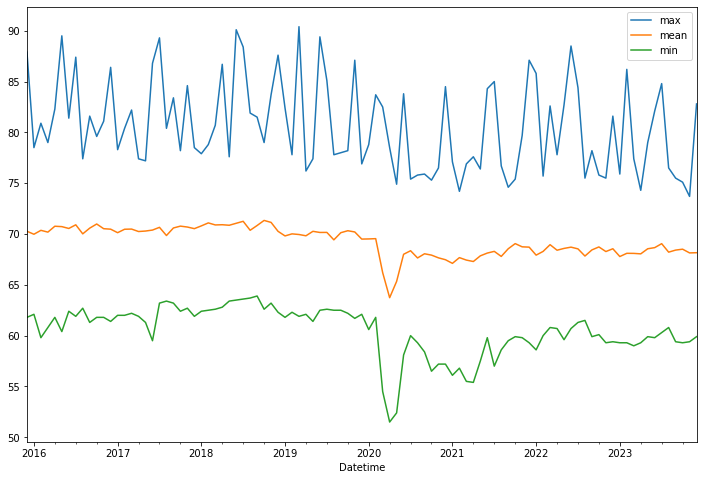

In [10]:
# Select sensor with more samples
max_sensor_id = df_noise.groupby('Id_Instal')['Id_Instal'].value_counts().sort_values(ascending=False).reset_index().iloc[0][0]

# Get the dataframe of a sensor
df_sensor = df_noise[df_noise['Id_Instal'] == max_sensor_id]

sensor_samples_max = df_sensor['Noise_db'].resample('ME').max()
sensor_samples_mean = df_sensor['Noise_db'].resample('ME').mean()
sensor_samples_min = df_sensor['Noise_db'].resample('ME').min()

# Plot the sensor values
plt.figure(figsize=(12,8))
sensor_samples_max.plot(label='max')
sensor_samples_mean.plot(label='mean')
sensor_samples_min.plot(label='min')
plt.legend()
plt.plot();

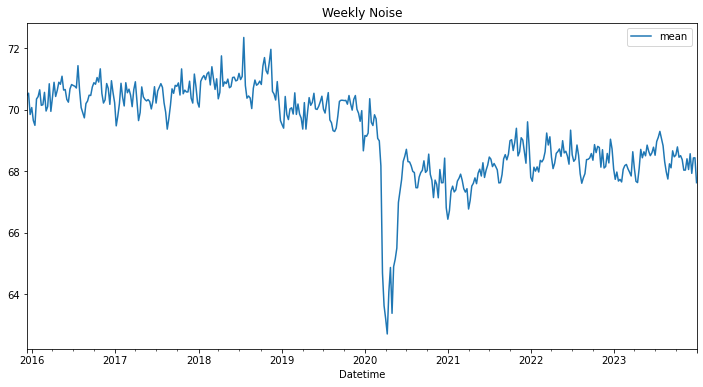

In [11]:
sensor_samples_mean = df_sensor['Noise_db'].resample('w').mean()

plt.figure(figsize=(12,6))
sensor_samples_mean.plot(label='mean')
plt.title('Weekly Noise')
plt.legend()
plt.plot();

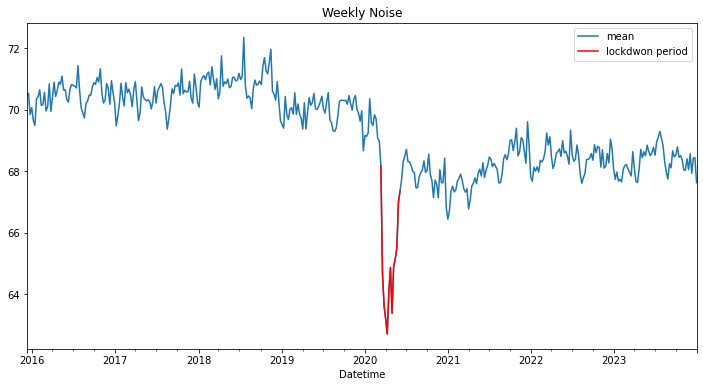

In [12]:
lockdown_start = '2020-03-14'
lockdown_end = '2020-06-07'

lockdown_data = sensor_samples_mean[
    (sensor_samples_mean.index >= lockdown_start) & 
    (sensor_samples_mean.index <= lockdown_end)
]


plt.figure(figsize=(12,6))
sensor_samples_mean.plot(label='mean')
lockdown_data.plot(label='lockdwon period', color='red')
plt.title('Weekly Noise')
plt.legend()
plt.plot();

## Missing values of sensor (to review)

In [13]:
# # Define the expected date range
# start_date = np.min(df_sensor.index)
# end_date = np.max(df_sensor.index)
# full_date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# # Add the index values of the missing data
# df_sensor = df_sensor.reindex(full_date_range)

# # Check for missing data
# missing_index = df_sensor[df_sensor['Noise_db'].isna()].index.tolist()

Interpolation method to fill in missed data

In [14]:
# df_sensor['Noise_db'] = df_sensor['Noise_db'].interpolate(method='polynomial', order=2)

In [15]:
# plt.figure(figsize=(12, 6))
# plt.plot(df_sensor.index, df_sensor['Noise_db'], label='Interpolated Data', color='blue')
# plt.title('Interpolated Noise Levels')
# plt.xlabel('Datetime')
# plt.ylabel('Noise Level (dB)')
# plt.legend()
# plt.show()

## Seasonal Decompose

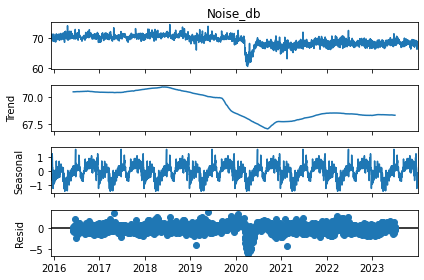

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(df_sensor['Noise_db'].resample('d').mean().fillna(df_sensor['Noise_db'].mean()), model='additive', period=365)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

<Axes: xlabel='Datetime'>

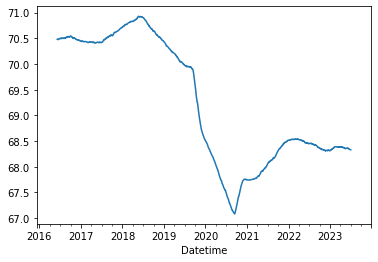

In [17]:
trend = result.trend
trend.plot()

## Forecasting...